# <font style="font-size:40px"><center><b>Machine Learning</b></center></font><font                        style="font-size:30px"><center><b>Master in Computational Finance (MCF) </b></center></font> 

<center> 

# 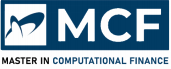

<center/>

# <font color='tomato' style="font-size:40px"><center><b>Homework 2</b></center></font></b></center></font> 

<center>
<b>profesor: </b> Nikola Vasiljevic

<b>students: </b> 
Nikola Krivacevic, Aleksandar Milinkovic
</center>





## Importing libraries:


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd  
from scipy.special import comb
import datetime as dt
import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import (SelectKBest, SelectPercentile, RFE, RFECV)

from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV)
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Supervised Learning

### Consider the California Housing Dataset that was studied and extensively discused in the lectures.

### (a) Data preprocessing: Provide a proposal on how to improve data preprocessing relative to the procedure described in the lecture notes. Evaluate the impact of different data treatment algorithms on the OLS regression results using the full dataset.Leverage the code provided in lecture notes as much as you can/want. Motivate your choices and discuss the results.

#### California housing dataset EDA

We'll work on California housing dataset and will try to model the linear relationship between house properities and house price. By understanding the semantics of the features we have in dataset, we can conclude that the observations are not single houses, but median values for California districts/counties.

Our `target variable` is house price - `MedHouseVal`.

Dataset `features/regressors`:
- MedInc - median income for the district
- House age
- AveRooms - average num. of rooms in the house
- Population - number of people living in the district
- AveOccup - average number of tenants in the house
- Latitude/Logitude - geo location of county

##### Dataset statistical properties

In [ ]:
# California housing dataset
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()

In [ ]:
# Create a dataframe containing observations
data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
data['MedHouseVal'] = california_housing.target
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [ ]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


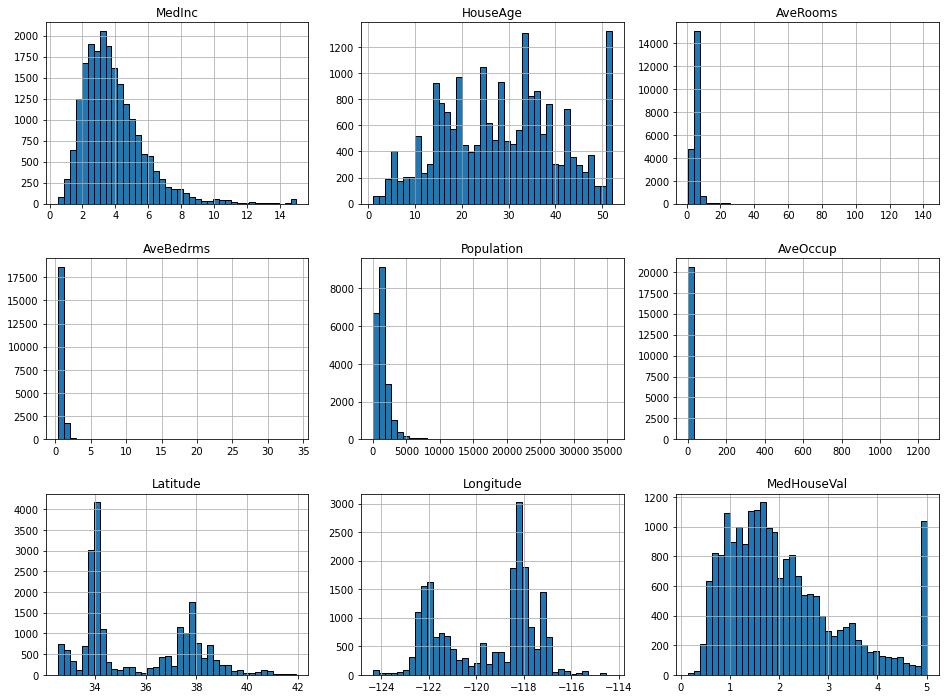

In [ ]:
data.hist(figsize=(16, 12), bins=40, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

We can see that in our dataset observations we have some data that could potentially seen as outliers. We could try to remove them and see if our OLS regression model would be improved compared the the OLS regression model fitter on original, non-transformed dataset.

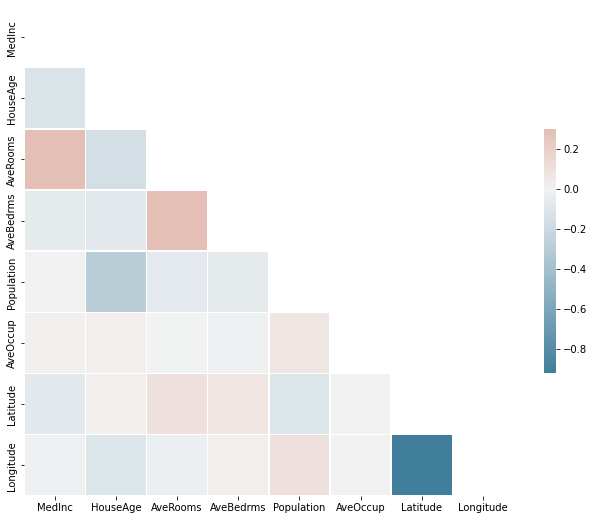

In [ ]:
corr = data.drop(columns=["MedHouseVal"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the correlation above we can see that the correalation between features in mostly low, around zero.

Exception to that is latitude and longitude which is highly negatively correlated (due to geographical direcation of California state).

Maybe to explore some reasoning about some non-zero correlations in our dataset:
- Low positive corelation between `AvgBedrooms` amd `MedInc` - that would makse sense as it's expected that individials and families who have a higher income to be living in a bigger housed
- `AvgBedrooms` and `AvgRooms`, although we don't know for sure how that are different with what they represent, we can see for that pair of features that they also have low, non-negative corerlation.

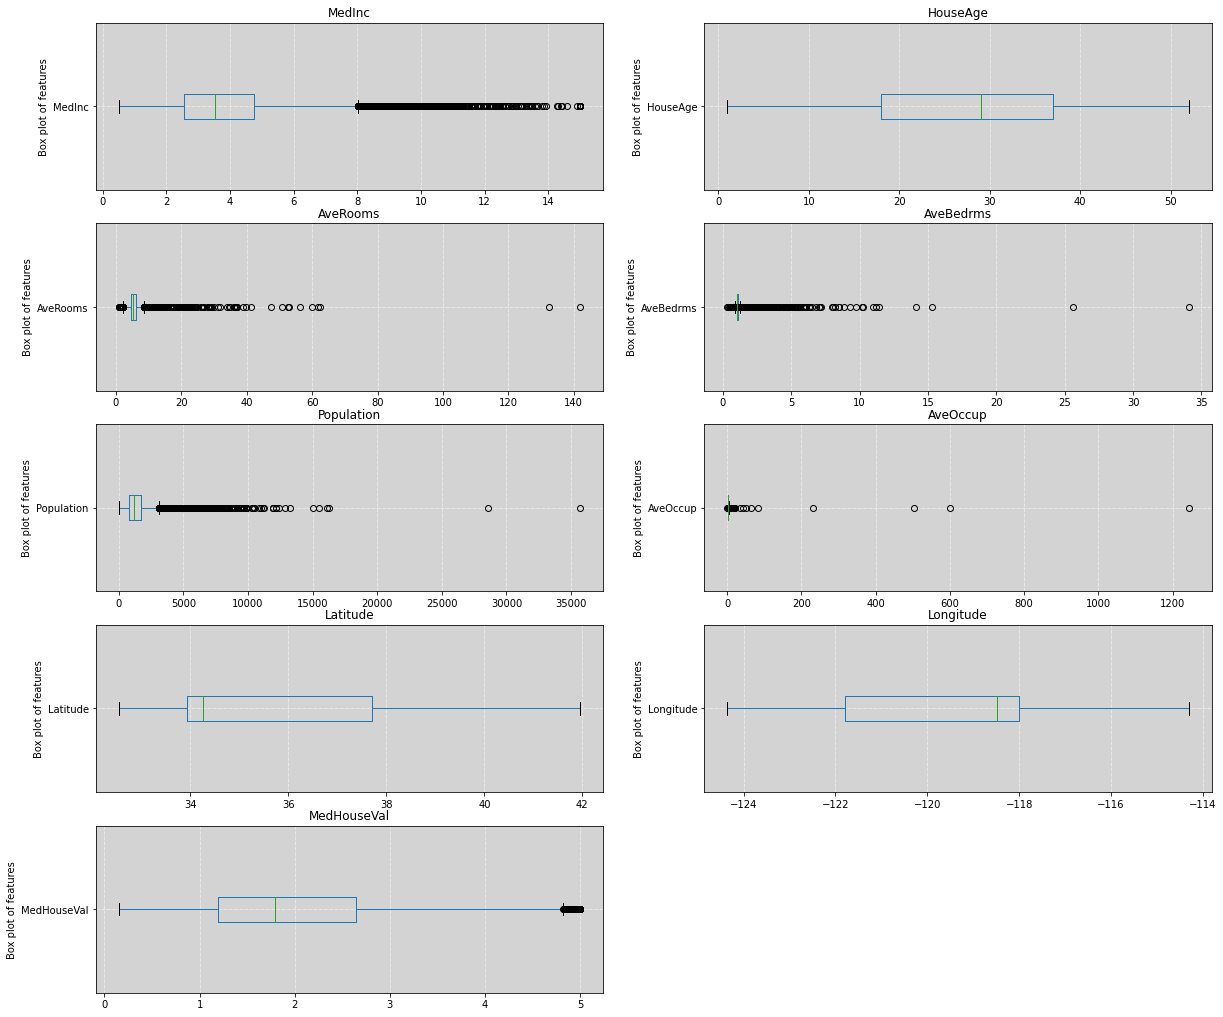

In [ ]:
plt.figure(figsize=(20, 40))

for i, column in enumerate(data.columns):
    # Create subplots
    plt.subplot(11, 2, i + 1)
    data[column].plot.box(vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Box plot of features')
    plt.title(column)
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

From the Box plots of features, we can see that there could be some outliers (points outside of box plot "whiskers"; observations are considered outliers if their distance from the 25th/75th percentile if greater than 1.5 * IRQ).

##### Removing outliers

Now let's go feature by feature and try to remove the observations that seem to be outliers:

###### Average occupancy feature

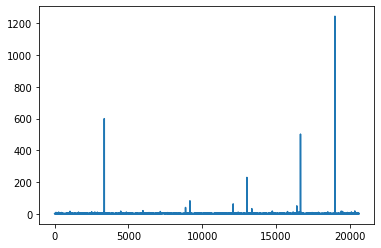

In [ ]:
data['AveOccup'].plot()

In [ ]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data[data['AveOccup'] > 8]
data_cleaned = data.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 53 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
91,0.8668,52.0,2.443182,0.988636,904.0,10.272727,37.80,-122.28,1.375
270,3.8750,33.0,3.021277,0.659574,575.0,12.234043,37.78,-122.18,2.250
460,1.4012,52.0,3.105714,1.060000,3337.0,9.534286,37.87,-122.26,1.750
1039,4.3029,16.0,6.090592,1.121951,4930.0,17.177700,38.42,-120.97,1.219
1067,3.4191,52.0,4.530612,0.816327,1107.0,11.295918,39.73,-121.85,1.375


###### Average rooms feature

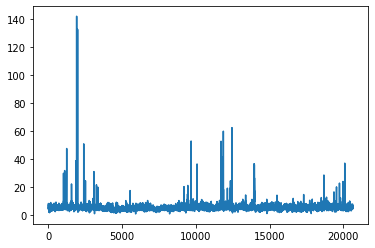

In [ ]:
data['AveRooms'].plot()

In [ ]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data_cleaned[data_cleaned['AveRooms'] > 10]
data_cleaned = data_cleaned.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 224 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1023,2.2417,15.0,10.515306,2.372449,573.0,2.923469,38.72,-119.93,0.979
1024,3.1500,16.0,29.852941,5.323529,202.0,1.980392,38.52,-120.00,1.406
1030,3.0125,15.0,10.168591,2.057737,1103.0,2.547344,38.55,-120.25,1.117
1102,2.4028,17.0,31.777778,9.703704,47.0,1.740741,40.06,-121.54,0.675
1233,3.7500,10.0,16.847534,3.237668,546.0,2.448430,38.23,-120.34,1.214


###### Average bedrooms feature

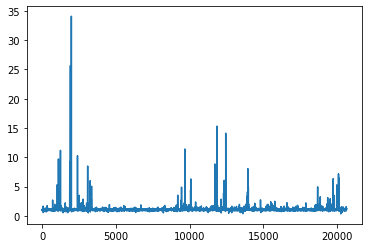

In [ ]:
data['AveBedrms'].plot()

In [ ]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data_cleaned[data_cleaned['AveBedrms'] > 2.5]
data_cleaned = data_cleaned.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 12 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
710,2.4196,26.0,8.518248,2.700730,253.0,1.846715,37.68,-122.08,2.750
1925,4.9583,10.0,5.062500,2.562500,55.0,3.437500,38.87,-120.50,0.875
2776,3.1607,18.0,9.314961,2.858268,374.0,2.944882,33.07,-114.98,0.575
3334,4.1250,30.0,5.384615,2.923077,20.0,1.538462,38.92,-122.65,1.125
12307,2.9141,11.0,9.855372,2.731405,682.0,2.818182,33.62,-116.74,2.143


###### Population feature

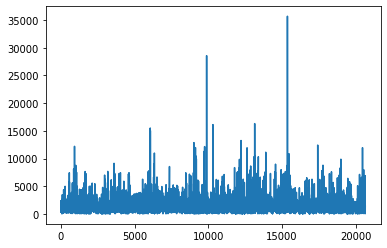

In [ ]:
data['Population'].plot()

In [ ]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data_cleaned[data['Population'] > 15000]
data_cleaned = data_cleaned.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 6 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
6057,6.0191,8.0,6.347327,1.047525,15507.0,3.070693,34.03,-117.78,2.539
6066,6.6288,7.0,6.802554,1.026277,15037.0,3.692780,34.04,-117.87,3.397
9880,2.3087,11.0,5.364518,1.059684,28566.0,4.696810,36.64,-121.79,1.188
10309,7.4947,4.0,7.311043,1.054346,16122.0,3.106957,33.89,-117.74,3.663
13139,4.9516,3.0,7.338559,1.159015,16305.0,3.043113,38.43,-121.44,1.537


###### Overview of the cleaned dataset

In [ ]:
# Original dataset
data.shape

(20640, 9)

In [ ]:
# Cleaned dataset
data_cleaned.shape

(20345, 9)

In [ ]:
# Number of removed observations
print(f'{round(100 * (data.shape[0] - data_cleaned.shape[0]) / data.shape[0], 2)} % of data has been removed as outliers.')
print(f'{data.shape[0] - data_cleaned.shape[0]} observations have been removed as outliers.')

1.43 % of data has been removed as outliers.
295 observations have been removed as outliers.


Let's look now Box plots once again, to see how the feature value distribution has changed after removing values:

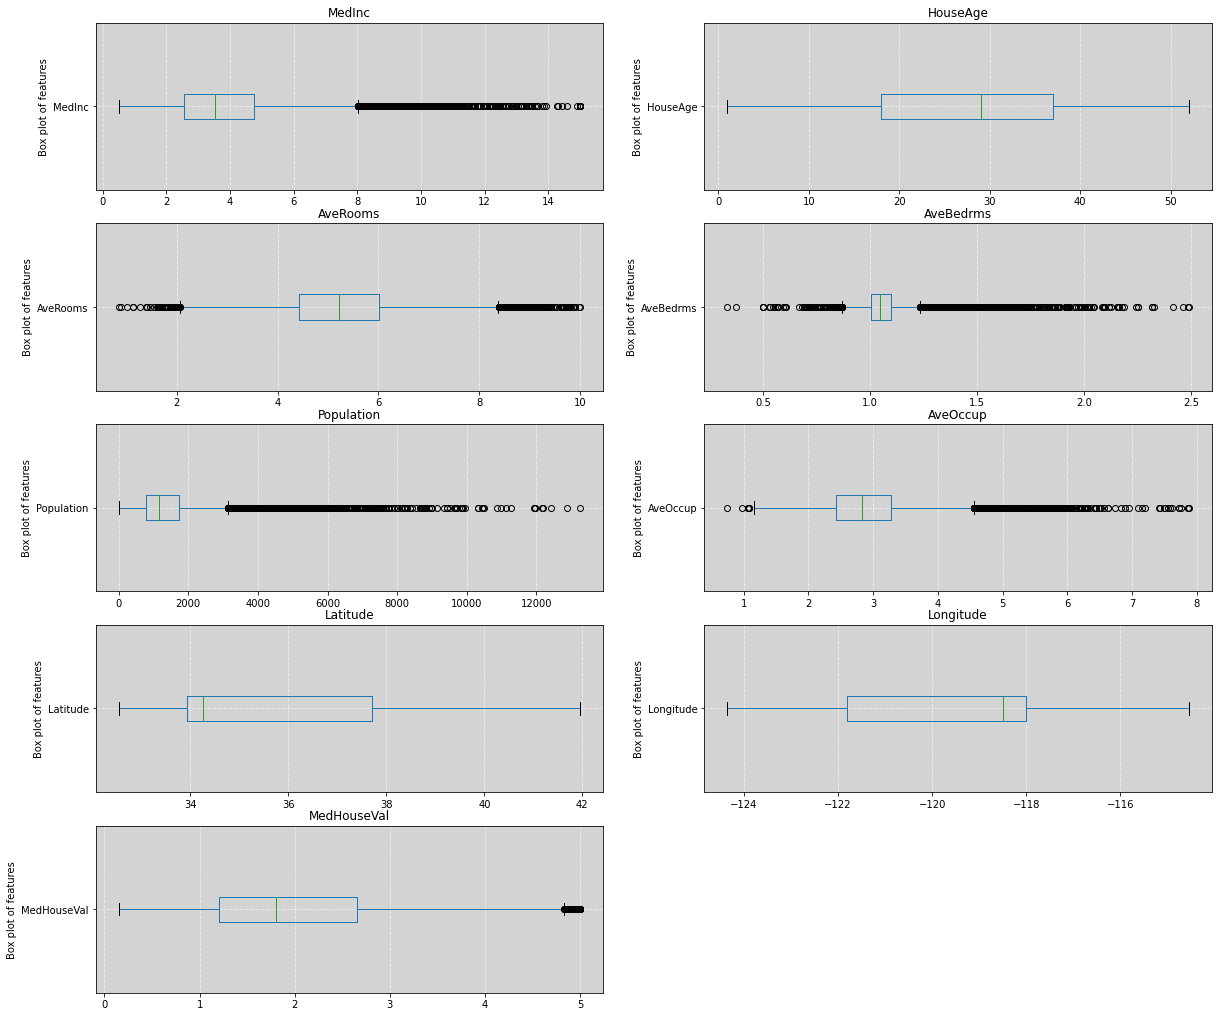

In [ ]:
plt.figure(figsize=(20, 40))

for i, column in enumerate(data_cleaned.columns):
    # Create subplots
    plt.subplot(11, 2, i + 1)
    data_cleaned[column].plot.box(vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Box plot of features')
    plt.title(column)
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

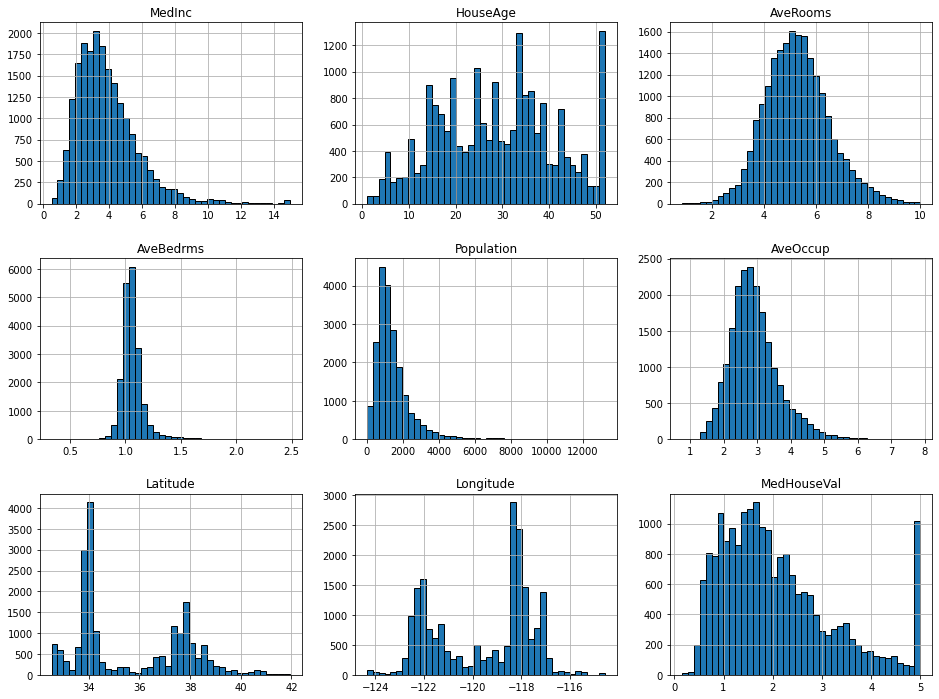

In [ ]:
data_cleaned.hist(figsize=(16, 12), bins=40, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

#### OLS regression on the original dataset

In [ ]:
# Evaluate the models using cross-validation
model_california_housing = make_pipeline(StandardScaler(), LinearRegression())
cv_california_housing    = cross_validate(model_california_housing, 
                                          data.drop(columns=['MedHouseVal']), data['MedHouseVal'],
                                          return_estimator=True, n_jobs=1, cv=10)

In [ ]:
# Get R-squared
score_california_housing = cv_california_housing['test_score']
print(f'R2 score: {score_california_housing.mean():.3f} +/- {score_california_housing.std():.3f}')

R2 score: 0.511 +/- 0.059


#### OLS regression on the cleaned dataset

In [ ]:
# Evaluate the models using cross-validation
model_california_housing = make_pipeline(StandardScaler(), LinearRegression())
cv_california_housing    = cross_validate(model_california_housing, 
                                          data_cleaned.drop(columns=['MedHouseVal']), data_cleaned['MedHouseVal'],
                                          return_estimator=True, n_jobs=1, cv=10)

In [ ]:
# Get R-squared
score_california_housing = cv_california_housing['test_score']
print(f'R2 score: {score_california_housing.mean():.3f} +/- {score_california_housing.std():.3f}')

R2 score: 0.580 +/- 0.048


#### Model comparison

We got that the model fitted on the cleaned dataset using OLS regression has a higher R-squared score.

|            | OLS (original dataset) | OLS (cleaned dataset) |
|------------|------------------------|-----------------------|
| R-squared  | 0.511 +/- 0.059        | 0.580 +/- 0.048.      |

### (b) Feature and model selection:

#### (b.1) Using your final (transformed) dataset, split the full sample into training and testing subsamples. Evaluate in-sample and out-of-sample performance for the following models: OLS, PLS, rigde, lasso, and elastic net regressions. For models which do not embed a variable selection procedure, consider specifications with different numbers of features. You can use performance metric(s) of your choice, however provide a rationale for your preferred approach.


In order to protect from overfitting our model, we're goind to perform feature selection or adding regularization terms to our models.

Our dataset contains just over 20,000 observations and 9 features. The number of observations is much larger than the number of features, so we don't expect dimensionality problems nor multicolinearity problem amoung features in dataset as we previously seen that the corrlerations are relatively low.

In [ ]:
data_cleaned.shape

(20345, 9)

In [ ]:
data_cleaned.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

Before we move on, we'll standardize the features and target variable:

In [ ]:
# Scale features
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data_cleaned)
X = scaled_data[:,0:-1]
y = scaled_data[:,-1].reshape(1,-1)

X.shape, y.shape

((20345, 8), (1, 20345))

Let's now also split our dataset into the:
- Training set (80% of the observations ~ 16,276 observations)
- Testing set (20% of the observations ~ 4,069 observations)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y[0,:], test_size=0.2, random_state=42)

print(f'Features: train={len(X_train)} test={len(X_test)}')
print(f'Target: train={len(y_train)} test={len(y_test)}')

Features: train=16276 test=4069
Target: train=16276 test=4069


#### 1.OLS Regression

Vanilla OLS regression doesn't have embeded feature selection or any overfitting prevention methods, we'll manually select features to include in the regression model.

For feature selection, we'll consider univariate feature selection. Regressions will be performed between every single feature and target variable, and based on that we'll chose a subset of features to include.

From the results down bellow we can see that based on two different metrics to evaluate univariate feature regressions, we can see that sets for K most important features is defferent. It's different for all different number of most important features (3-7 of them). Only when we select 7 best features we got the same set of features when evaluated with different metrics.


In [ ]:
# SelectKBest
for n_select in [3, 4, 5, 6, 7]:
  # Performance metric: f_regression
  kbest_freg_california_housing  = SelectKBest(score_func=f_regression, k=n_select)  
  X_scaled_kbest_freg            = kbest_freg_california_housing.fit_transform(X, y[0,:])
  mask_kbest_freg                = kbest_freg_california_housing.get_support()
  feature_names_kbest_freg       = data_cleaned.columns[:-1][mask_kbest_freg]

  # Performance metric: mutual_info_regression
  kbest_mireg_california_housing = SelectKBest(score_func=mutual_info_regression, k=n_select)  
  X_scaled_kbest_mireg           = kbest_mireg_california_housing.fit_transform(X, y[0,:])
  mask_kbest_mireg               = kbest_mireg_california_housing.get_support()
  feature_names_kbest_mireg      = data.columns[:-1][mask_kbest_mireg]

  print(f'{n_select} features')
  print(f'SelectKBest (f_regression): {", ".join(feature_names_kbest_freg)}.')
  print(f'SelectKBest (mutual_info_regression): {", ".join(feature_names_kbest_mireg)}.')
  print('-'*20)

3 features
SelectKBest (f_regression): MedInc, AveRooms, AveOccup.
SelectKBest (mutual_info_regression): MedInc, Latitude, Longitude.
--------------------
4 features
SelectKBest (f_regression): MedInc, AveRooms, AveOccup, Latitude.
SelectKBest (mutual_info_regression): MedInc, AveRooms, Latitude, Longitude.
--------------------
5 features
SelectKBest (f_regression): MedInc, HouseAge, AveRooms, AveOccup, Latitude.
SelectKBest (mutual_info_regression): MedInc, AveRooms, AveOccup, Latitude, Longitude.
--------------------
6 features
SelectKBest (f_regression): MedInc, HouseAge, AveRooms, AveBedrms, AveOccup, Latitude.
SelectKBest (mutual_info_regression): MedInc, HouseAge, AveRooms, AveOccup, Latitude, Longitude.
--------------------
7 features
SelectKBest (f_regression): MedInc, HouseAge, AveRooms, AveBedrms, AveOccup, Latitude, Longitude.
SelectKBest (mutual_info_regression): MedInc, HouseAge, AveRooms, AveBedrms, AveOccup, Latitude, Longitude.
--------------------


Because we couldn't manually determine the number and which features to use for our model, based on univariate testing, now we'll try to determine the optimal number of features and which one to use. For that, Recursive feature elimination with cross-validation to select the number of features is used (from scikit-learn package).

The minumum number of features we'll set to be 4, out of 8 features in total.



In [ ]:
# Backward stepwise selection using scikit-learn RFECV
n_min_select = 4
n_cv_rfe     = 10

ols_estimator   = LinearRegression()
rfecv_estimator = RFECV(estimator=ols_estimator, min_features_to_select=n_min_select, step=1, cv=n_cv_rfe)

rfecv_california_housing = rfecv_estimator.fit_transform(X, y[0,:])
mask_rfecv_california_housing = rfecv_estimator.get_support()
feature_names_rfecv_california_housing = data_cleaned.columns[:-1][mask_rfecv_california_housing]

print(f'The optimal number of features using RFECV: {rfecv_estimator.n_features_}.')
print(f'The selected features using RFECV: {feature_names_rfecv_california_housing}.')

The optimal number of features using RFECV: 8.
The selected features using RFECV: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object').


We got that we should use 8 features (all of them):
- Population
- AveOccup
- Latitude
- Longitude
- MedInc
- HouseAge
- AveRooms
- Avebedrms


In the previous step we got that the optimal features to use is all. Now let's try to select the optimal 4 (half of them) features to use. We'll create and evaluate the model using both the best 4 features and all features.

We're running Recursive feature elimination (RFE) to select features by recursively considering smaller and smaller sets of features. 

In the results bellow we got the the optimal 4 features to use are:

- 'MedInc'
- 'AveOccup'
- 'Latitude'
- 'Longitude'

All of that makes sense. Two columns are about location, and in real estate market the most important thing is location. AveOccup says how big the house is, how many poople live in it. And MedInc explains if it's a rich or poor neighbourhood

In [ ]:
# Backward stepwise selection using scikit-learn RFE
n_select = 4

ols_estimator   = LinearRegression()
rfe_estimator = RFE(estimator=ols_estimator, n_features_to_select=n_select, step=1)

rfe_california_housing = rfe_estimator.fit_transform(X, y[0,:])
mask_rfe_california_housing = rfe_estimator.get_support()
feature_names_rfe_california_housing = data_cleaned.columns[:-1][mask_rfe_california_housing]

print(f'The selected {n_select} features using RFE: {feature_names_rfe_california_housing}.')

The selected 4 features using RFE: Index(['MedInc', 'AveOccup', 'Latitude', 'Longitude'], dtype='object').


In [ ]:
# Indexes of selected 4 features
feature_indexes = []
for i, col in enumerate(data_cleaned.columns):
  if col in feature_names_rfe_california_housing:
    feature_indexes.append(i)
feature_indexes, data_cleaned.columns

([0, 5, 6, 7],
 Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
        'Latitude', 'Longitude', 'MedHouseVal'],
       dtype='object'))

In [ ]:
# Selected features for OLS regression
X_train_select = X_train[:, feature_indexes]
X_test_select = X_test[:, feature_indexes]
X_train_select.shape

(16276, 4)

**In-sample evaluation**

Let's now perform in-sample model evalidation using K-fold cross validation to find the optimal model parameters. We'll do regression model wiith all features and with a selected number of them.

For the in-sample evaluation, we'll look at R-squared score and RMSE (or negative of root mean square error; using negation for consistency reason if finding the model with the highest score).

1. Selected features:

In [ ]:
# Evaluate the models using crossvalidation
ols_model = LinearRegression()
scores_select = cross_validate(ols_model, X_train_select, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
scores_select['test_neg_root_mean_squared_error']

array([-0.56584846, -0.63115635, -0.56827794, -0.59079927, -0.59273371,
       -0.58972412, -0.57636591, -0.59229836, -0.61035616, -0.61984955])

In [ ]:
scores_select['test_r2']

array([0.65206427, 0.60846636, 0.65669822, 0.6464273 , 0.64894946,
       0.66361487, 0.66464173, 0.65099599, 0.62956916, 0.6303831 ])

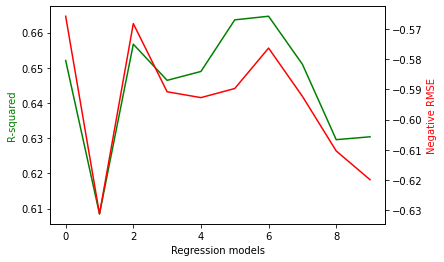

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores_select['test_r2'], 'g-')
ax2.plot(scores_select['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('Regression models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

From the 10 different models built and evaluated in the cross validation, we can see that there isn't a signle model which is best for both metrics.

We'll prioritize R-squared metrics over RMSE.

So the best in-sample performing model is model 6!

In [ ]:
# Intercept and coefficients
scores_select['estimator'][6].intercept_, scores_select['estimator'][6].coef_

(-0.001215613579151392,
 array([ 0.58148   , -0.23291029, -0.93985135, -0.86906289]))

In [ ]:
# Model that we'll use for out of sample forecast
regression_ols_selected = scores_select['estimator'][6]

In [ ]:
# Saving performance results to dataframe
model_comparison = pd.DataFrame([], columns=['Model', 'R-squared (in-sample)', 'RMSE (in-sample)', 'RMSE (out-of-the-sample)'])
model_comparison.loc[0] = ['OLS (4 features)', scores_select['test_r2'][6], -scores_select['test_neg_root_mean_squared_error'][6], ""]

2. All features:

In [ ]:
# Evaluate the models using crossvalidation
scores_all = cross_validate(ols_model, X_train, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
scores_all['test_r2']

array([0.67496562, 0.62342865, 0.66965402, 0.66914844, 0.67229613,
       0.68318712, 0.67891389, 0.67617007, 0.64784193, 0.65412038])

In [ ]:
scores_all['test_neg_root_mean_squared_error']

array([-0.54690925, -0.61897919, -0.55745174, -0.57150125, -0.5726847 ,
       -0.57231076, -0.56396809, -0.57053699, -0.59511183, -0.59961552])

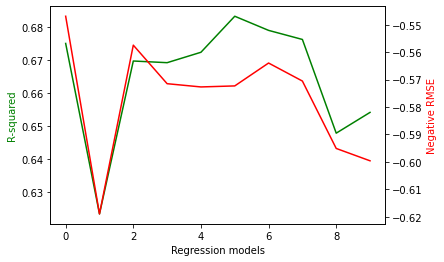

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores_all['test_r2'], 'g-')
ax2.plot(scores_all['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('Regression models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

Here the model with the highest R-squared score is model 5. The Difference in RMSE between top performing models isn't so wide spread.

In [ ]:
# Intercept and coefficients
scores_all['estimator'][5].intercept_, scores_all['estimator'][5].coef_

(0.0013703972047001724,
 array([ 0.70612631,  0.12250136, -0.10915646,  0.10647406,  0.04257997,
        -0.22210976, -0.80018055, -0.73693909]))

In [ ]:
# Model that we'll use for out of sample forecast
regression_ols_all = scores_all['estimator'][5]

In [ ]:
# Saving performance results to dataframe
model_comparison.loc[1] = ['OLS (all features)', scores_all['test_r2'][5], -scores_all['test_neg_root_mean_squared_error'][5], ""]

**Out-of-the-sample evaluation**

Now let's perform out-of-the-sample evaluation on our test dataset. For measuring performance of test set, we'll use RMSE.

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

1. Model with 4 features

In [ ]:
# Evaluation on test set
y_pred_select = regression_ols_selected.predict(X_test_select)
error = rmse(y_test, y_pred_select)
error

0.6080983700570384

In [ ]:
# Update model comparison table
model_comparison.loc[0, 'RMSE (out-of-the-sample)'] = error

2. Model with all features

In [ ]:
# Evaluation on test set
y_pred_select = regression_ols_all.predict(X_test)
error = rmse(y_test, y_pred_select)
error

0.5860471752200825

In [ ]:
# Update model comparison table
model_comparison.loc[1, 'RMSE (out-of-the-sample)'] = error

**Model comparison**

As we can see from the table bellow, OLS model using only 4 features had a lower R-squared score in-sample, and out-of-the-sample it performed slightly worse (higher RMSE).

All in all, OLS regression on all features was the best performing model.

In [ ]:
model_comparison

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-the-sample)
0,OLS (4 features),0.664642,0.576366,0.608098
1,OLS (all features),0.683187,0.572311,0.586047


#### 2.PLS Regression

Partial least squares (PLS) regression is a technique that reduces the predictors to a smaller set of uncorrelated components and performs least squares regression on these components, instead of on the original data. PLS regression is especially useful when your predictors are highly collinear, or when you have more predictors than observations and ordinary least-squares regression either produces coefficients with high standard errors or fails completely.

Because of embeded properties of PLS regression, that are similar to PCA, we won't be doing feature selection for this regression model.

**In-sample evaluation**

In [ ]:
# Evaluate the models using crossvalidation
pls_model = PLSRegression(n_components = 4)
scores = cross_validate(pls_model, X_train, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
# Cross-validation: R-squared
scores['test_r2']

array([0.65261083, 0.59638208, 0.63969426, 0.64772284, 0.6445598 ,
       0.65037066, 0.65119276, 0.65934829, 0.61692328, 0.62913278])

In [ ]:
# Cross-validation: RMSE (negative)
scores['test_neg_root_mean_squared_error']

array([-0.56540384, -0.64082232, -0.58218144, -0.5897159 , -0.59642807,
       -0.60122141, -0.58780939, -0.58516805, -0.62068699, -0.62089706])

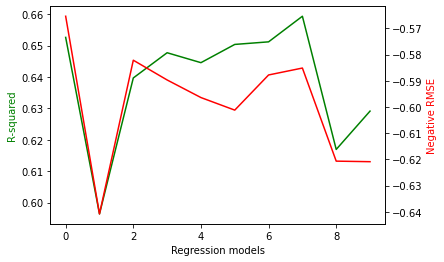

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores['test_r2'], 'g-')
ax2.plot(scores['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('Regression models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

Following already established rules for in-sample model evaluation and selection, the best performing model is model 0. It has the second lowest R-squared score and the lowest RMSE.

In [ ]:
# Model that we'll use for out of sample forecast
regression_pls = scores['estimator'][0]

In [ ]:
# Intercept and coefficients
scores['estimator'][0].coef_

array([[ 0.80882126],
       [ 0.1846303 ],
       [-0.17242599],
       [ 0.14307735],
       [ 0.12823572],
       [-0.23576525],
       [-0.39613419],
       [-0.30751056]])

In [ ]:
# Saving performance results to dataframe
model_comparison.loc[2] = ['PLS', scores['test_r2'][0], -scores['test_neg_root_mean_squared_error'][0], ""]
model_comparison

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-the-sample)
0,OLS (4 features),0.664642,0.576366,0.608098
1,OLS (all features),0.683187,0.572311,0.586047
2,PLS,0.652611,0.565404,


**Out-of-the-sample evaluation**

In [ ]:
# Evaluation on test set
y_pred_select = regression_pls.predict(X_test)
error = rmse(y_test, y_pred_select)
error

1.2723136557008117

In [ ]:
# Update model comparison table
model_comparison.loc[2, 'RMSE (out-of-the-sample)'] = error
model_comparison

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-the-sample)
0,OLS (4 features),0.664642,0.576366,0.608098
1,OLS (all features),0.683187,0.572311,0.586047
2,PLS,0.652611,0.565404,1.27231


Now we'll move to `regularized regressions`. They prevent overfitting by adding a panalization term to the loss function, which penalizes more complex models, similar like AIC and BIC score do.

#### 3.Ridge Regression

For Rigde regression increasing the hyperparameter  𝜆  shrinks the coefficients toward zero. For this reason,  𝜆  is often called `shrinkage intensity`.

Unlike LASSO regression, [RIDGE regression does not have zeroing coefficients as a goal](https://stats.stackexchange.com/questions/151954/sparsity-in-lasso-and-advantage-over-ridge-statistical-learning/151960#151960), which means that `ridge regression does not help with the variables selection`. It is possible that some coefficients will be equal to zero, but that's

Similar like for OLS regression, we'll first perform the feature selection process.

At the beginning we tried to perform feature selection based on univariate testing, now we'll try to determine the optimal number of features and which one to use. As a consequecnce, recursive feature elimination with cross-validation will be used to select the number of features is used (from scikit-learn package).


The minumum number of features we'll set to be 4, out of 8 features in total.

Similar as for the OLS, we got that we should use all features.


In [ ]:
# Backward stepwise selection using scikit-learn RFECV
lambda_param = 100
n_min_select = 4
n_cv_rfe     = 10

model_ridge = Ridge(alpha=lambda_param)
rfecv_estimator = RFECV(estimator=model_ridge, min_features_to_select=n_min_select, step=1, cv=n_cv_rfe)

rfecv_california_housing = rfecv_estimator.fit_transform(X, y[0,:])
mask_rfecv_california_housing = rfecv_estimator.get_support()
feature_names_rfecv_california_housing = data_cleaned.columns[:-1][mask_rfecv_california_housing]

print(f'The optimal number of features using RFECV: {rfecv_estimator.n_features_}.')
print(f'The selected features using RFECV: {feature_names_rfecv_california_housing}.')

The optimal number of features using RFECV: 8.
The selected features using RFECV: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object').


In the previous step we got that the optimal features to use is all. Now let's try to select the optimal 4 (half of them) features to use. We'll create and evaluate the model using both the best 4 features and all features.

We're running Recursive feature elimination (RFE) to select features by recursively considering smaller and smaller sets of features. 

In the results bellow we got the the optimal 4 features to use are:

- 'MedInc'
- 'AveOccup'
- 'Latitude'
- 'Longitude'

Those are the same features that we got for OLS regressing using backward stepwise selection.

In [ ]:
# Backward stepwise selection using scikit-learn RFE
n_select = 4
lambda_param = 100

model_ridge = Ridge(alpha=lambda_param)
rfe_estimator = RFE(estimator=model_ridge, n_features_to_select=n_select, step=1)

rfe_california_housing = rfe_estimator.fit_transform(X, y[0,:])
mask_rfe_california_housing = rfe_estimator.get_support()
feature_names_rfe_california_housing = data_cleaned.columns[:-1][mask_rfe_california_housing]

print(f'The selected {n_select} features using RFE: {feature_names_rfe_california_housing}.')

The selected 4 features using RFE: Index(['MedInc', 'AveOccup', 'Latitude', 'Longitude'], dtype='object').


**In sample evaluation**

1. Selected features

In [ ]:
# Evaluate the models using crossvalidation
model_ridge = Ridge(alpha=100)
scores_select = cross_validate(model_ridge, X_train_select, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
# Cross-validation: R-squared
scores_select['test_r2']

array([0.65112807, 0.60841139, 0.65593906, 0.64538469, 0.6474118 ,
       0.66316019, 0.66337881, 0.65131412, 0.62789978, 0.62875737])

In [ ]:
# Cross-validation: RMSE (negative)
scores_select['test_neg_root_mean_squared_error']

array([-0.56660922, -0.63120065, -0.56890592, -0.59166971, -0.59403042,
       -0.59012254, -0.57745015, -0.59202834, -0.61172992, -0.62121123])

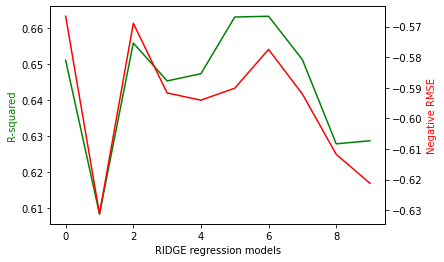

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores_select['test_r2'], 'g-')
ax2.plot(scores_select['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('RIDGE regression models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

AS best performing in-sample model we'll chose model6!

In [ ]:
# Intercept and coefficients
scores_select['estimator'][6].intercept_, scores_select['estimator'][6].coef_

(-0.0012123553366365897,
 array([ 0.58517129, -0.2320018 , -0.8588067 , -0.78835302]))

In [ ]:
# Model that we'll use for out of sample forecast
regression_ridge_selected = scores_select['estimator'][6]

In [ ]:
# Saving performance results to dataframe
model_comparison.loc[3] = ['RIDGE (4 features)', scores_select['test_r2'][6], -scores_select['test_neg_root_mean_squared_error'][6], ""]

2. All features:

In [ ]:
# Evaluate the models using crossvalidation
scores_all = cross_validate(model_ridge, X_train, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
scores_all['test_r2']

array([0.6748906 , 0.62310505, 0.66951139, 0.66860664, 0.67069328,
       0.68235439, 0.67798425, 0.67707129, 0.64597592, 0.65283276])

In [ ]:
scores_all['test_neg_root_mean_squared_error']

array([-0.54697236, -0.61924509, -0.55757207, -0.571969  , -0.57408354,
       -0.57306242, -0.56478393, -0.56974254, -0.59668644, -0.60073059])

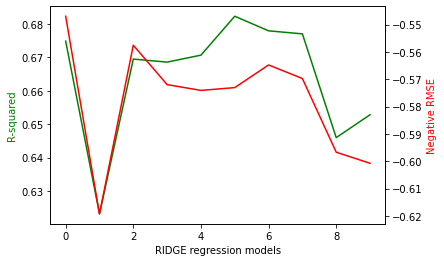

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores_all['test_r2'], 'g-')
ax2.plot(scores_all['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('RIDGE regression models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

Here the model with the highest R-squared score is model 5. The Difference in RMSE between top performing models isn't so wide spread. we could make a compromise and select the model that optimizes the both score. In this case it would be model 0:
- Lowest RMSE
- Nearly the hugher R-squared

In [ ]:
# Intercept and coefficients
scores_all['estimator'][0].intercept_, scores_all['estimator'][0].coef_

(0.001731834842365469,
 array([ 0.70488849,  0.12628465, -0.11303692,  0.10255655,  0.04191976,
        -0.22406762, -0.72973662, -0.66867968]))

In [ ]:
# Model that we'll use for out of sample forecast
regression_ridge_all = scores_all['estimator'][0]

In [ ]:
# Saving performance results to dataframe
model_comparison.loc[4] = ['RIDGE (all features)', scores_all['test_r2'][5], -scores_all['test_neg_root_mean_squared_error'][5], ""]

**Out-of-the-sample evaluation**

1. Model with 4 features

In [ ]:
# Evaluation on test set
y_pred_select = regression_ridge_selected.predict(X_test_select)
error = rmse(y_test, y_pred_select)
error

0.6098316887555134

In [ ]:
# Update model comparison table
model_comparison.loc[3, 'RMSE (out-of-the-sample)'] = error

2. Model with all features

In [ ]:
# Evaluation on test set
y_pred_select = regression_ridge_all.predict(X_test)
error = rmse(y_test, y_pred_select)
error

0.5872467073646777

In [ ]:
# Update model comparison table
model_comparison.loc[4, 'RMSE (out-of-the-sample)'] = error

**Model comparison**

As we can see from the table bellow, RIDGE regression model using only 4 features had a lower R-squared score in-sample, and in out-of-the-sample it performed slightly worse (higher RMSE). The RMSE for in-the-sample performance was nearly the same.

All in all, RIDGE regression on all features was the best performing model.

In [ ]:
model_comparison.loc[3:5]

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-the-sample)
3,RIDGE (4 features),0.663379,0.577450,0.609832
4,RIDGE (all features),0.682354,0.573062,0.587247


#### 4.Lasso Regression

Lasso regression similarly to the ridge regression adds a regularization term. The difference compared to the ridge regression is that  ℓ1  norm which defines the penalty term pulls many coeffcients to zero. Because LASSO regression is often used even as a predprocessing step for feature selection.

**In-sample evaluation**

In [ ]:
# Evaluate the models using crossvalidation
lasso_model = LassoCV(cv=10)
scores = cross_validate(lasso_model, X_train, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
# Cross-validation: R-squared
scores['test_r2']

array([0.67501994, 0.62350083, 0.66988005, 0.66907049, 0.67214237,
       0.6831441 , 0.67891142, 0.67630332, 0.64765244, 0.65396479])

In [ ]:
# Cross-validation: RMSE (negative)
scores['test_neg_root_mean_squared_error']

array([-0.54686355, -0.61891987, -0.55726099, -0.57156857, -0.57281904,
       -0.57234962, -0.56397026, -0.5704196 , -0.59527192, -0.59975037])

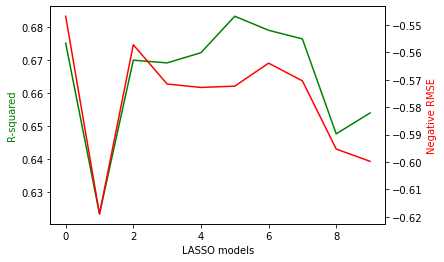

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores['test_r2'], 'g-')
ax2.plot(scores['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('LASSO models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

Again, the same compromise between the R-squared and RMSE score when choosing the best fit model. We can go with model 0, which gives us the best from both worlds

In [ ]:
# Model that we'll use for out of sample forecast
regression_lasso = scores['estimator'][0]

In [ ]:
# Intercept and coefficients
scores['estimator'][0].coef_

array([ 0.69925813,  0.12023611, -0.10850869,  0.10465326,  0.03925168,
       -0.22371301, -0.79700011, -0.73528534])

In [ ]:
# Saving performance results to dataframe
model_comparison.loc[5] = ['LASSO', scores['test_r2'][0], -scores['test_neg_root_mean_squared_error'][0], ""]

**Out-of-the-sample evaluation**

In [ ]:
# Evaluation on test set
y_pred_select = regression_lasso.predict(X_test)
error = rmse(y_test, y_pred_select)
error

0.5862327657144357

In [ ]:
# Update model comparison table
model_comparison.loc[5, 'RMSE (out-of-the-sample)'] = error
model_comparison.loc[5]

Model                          LASSO
R-squared (in-sample)        0.67502
RMSE (in-sample)            0.546864
RMSE (out-of-the-sample)    0.586233
Name: 5, dtype: object

#### 5. Elastic Net Regression

In the two previous sections, we we're modeling housing prices using RIDGE and LASSO regression models.

In this section, we're going to work with `Elastic net regression`. It combines the best from both worlds; uses both the ℓ1  and  ℓ2  penalties.


**In-sample evaluation**

In [ ]:
# Evaluate the models using crossvalidation
elastic_net_model = ElasticNetCV(cv=10)
scores = cross_validate(elastic_net_model, X_train, y_train, scoring=['r2','neg_root_mean_squared_error'], cv=10, return_estimator=True)

In [ ]:
# Cross-validation: R-squared
scores['test_r2']

array([0.67506751, 0.62350828, 0.66990187, 0.66905911, 0.67201128,
       0.6830973 , 0.67885122, 0.67646124, 0.64748707, 0.65387124])

In [ ]:
# Cross-validation: RMSE (negative)
scores['test_neg_root_mean_squared_error']

array([-0.54682353, -0.61891375, -0.55724258, -0.5715784 , -0.57293355,
       -0.57239188, -0.56402313, -0.57028044, -0.5954116 , -0.59983143])

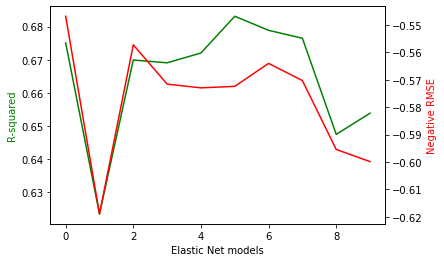

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores['test_r2'], 'g-')
ax2.plot(scores['test_neg_root_mean_squared_error'], 'r-')

ax1.set_xlabel('Elastic Net models')
ax1.set_ylabel('R-squared', color='g')
ax2.set_ylabel('Negative RMSE', color='r')

plt.show()

Again, the performance is nearly the same as for the previous models. We'll continue with model 0 (nearly the gighest score for both the R-squared and negative RMSE),

In [ ]:
# Model that we'll use for out of sample forecast
regression_elastic_net = scores['estimator'][0]

In [ ]:
# Intercept and coefficients
scores['estimator'][0].coef_

array([ 0.69991546,  0.1209169 , -0.1089752 ,  0.10426295,  0.03946997,
       -0.22370285, -0.78832464, -0.72668168])

In [ ]:
# Saving performance results to dataframe
model_comparison.loc[6] = ['ELASTIC NET', scores['test_r2'][0], -scores['test_neg_root_mean_squared_error'][0], ""]

**Out-of-the-sample evaluation**

In [ ]:
# Evaluation on test set
y_pred_select = regression_elastic_net.predict(X_test)
error = rmse(y_test, y_pred_select)
error

0.5863200866800539

In [ ]:
# Update model comparison table
model_comparison.loc[6, 'RMSE (out-of-the-sample)'] = error
model_comparison.loc[6]

Model                       ELASTIC NET
R-squared (in-sample)          0.675068
RMSE (in-sample)               0.546824
RMSE (out-of-the-sample)        0.58632
Name: 6, dtype: object

#### (b.2) Create a summary table (and/or a chart) that displays different model specifications and the corresponding in-sample and out-of-sample performance metrics.

Here is the complete overview of all models (one/best performing model from each regression group) that were evaluated in-the-sample and out-of-the-sample:

In [ ]:
model_comparison

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-the-sample)
0,OLS (4 features),0.664642,0.576366,0.608098
1,OLS (all features),0.683187,0.572311,0.586047
2,PLS,0.652611,0.565404,1.27231
3,RIDGE (4 features),0.663379,0.577450,0.609832
4,RIDGE (all features),0.682354,0.573062,0.587247
5,LASSO,0.675020,0.546864,0.586233
6,ELASTIC NET,0.675068,0.546824,0.58632


For models that don't have embeded feature selection:
- OLS regression
- Ridge regression
we performed feature selection

in table there are results for those models when fitted on all featured and when fitted on 4 most important features (determined using backward stepwise selection).

For other models that have some sort of feature selection:
- PLS regression
- LASSO regression
- ELASTIC NET regression

in the table we see the results for them as well.

#### (b.3) Draw a conclusion which features are most important and which models perform best, and discuss your results.

We already briefly discussed and compared model performance for every new group of models that we fittet.

Now we'll just once again look at all the models and how how they performed both in-the-sample and out-of-the-sample.

First of all, we must notice that all of the models performed nearly the same. There is only a slight variation between them. The only outlier from that statement is PLS regression model, which had the worst RMSE on testing set.

When looking the `R-squared` for `training set` the highest score have:
- OLS (all features)
- RIDGE (all features)	

Moving to the `RMSE` for the `trainig set` the lowest error that models have are models:
- LASSO
- ELASTIC NET

And most importantly, how they all perform on `testing set`? The best four models, in term of the `lowest RMSE` are the previously mentioned four models and they have the error equal to the level of three decimal points (`0.586`):
- OLS (all features)
- RIDGE (all features)	
- LASSO
- ELASTIC NET
 

Now let's look at regression coefficients for our models:

In [ ]:
# Coefficients
columns = ['Model']
columns.extend([c for c in data_cleaned.columns[:-1]])
models = [regression_ols_all, regression_pls, regression_ridge_all, regression_lasso, regression_elastic_net]
regression_coef = pd.DataFrame([], columns=columns)

for i, model in enumerate(models):
  row = [str(model)]
  row.extend(model.coef_)
  regression_coef.loc[i] = row
  

In [ ]:
regression_coef

,Model,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,LinearRegression(),0.706126,0.122501,-0.109156,0.106474,0.04258,-0.22211,-0.800181,-0.736939
1,PLSRegression(n_components=4),[0.8088212621974415],[0.18463030048918883],[-0.17242598627103706],[0.14307735200423388],[0.12823571902910466],[-0.23576524628490186],[-0.39613418795018457],[-0.3075105622168971]
2,Ridge(alpha=100),0.704888,0.126285,-0.113037,0.102557,0.0419198,-0.224068,-0.729737,-0.66868
3,LassoCV(cv=10),0.699258,0.120236,-0.108509,0.104653,0.0392517,-0.223713,-0.797,-0.735285
4,ElasticNetCV(cv=10),0.699915,0.120917,-0.108975,0.104263,0.03947,-0.223703,-0.788325,-0.726682


Ignoring the PLS regression, which we previously saw that had the worst performance, we can see that the coefficients for all regression models are nearly the same.

The least important feature is Population, coefficient for it is around 0.04. Median Income for district feature is one of the most important one. But the most important feature that higly affects the house price is location - Latitude and Longitude. Other coefficients, doesn't seem to be especially important. AveOccup with the average coeff. value of around 0.22 is somewhere important compared to the rest features.